In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.core import Tensor, TensorTKD, residual_tensor
from hottbox.algorithms.decomposition import HOSVD, HOOI
from coursework.data import get_image, plot_tensors

In [3]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [4]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [5]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618074


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [6]:
# Create a tensor
I, J, K, L = 5, 11, 7, 3
tensor_4d = Tensor(np.arange(I * J * K * L).reshape(I, J, K, L).astype(np.float))
tensor_4d

This tensor is of order 4 and consists of 1155 elements.
Sizes and names of its modes are (5, 11, 7, 3) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.

In [7]:
# Perform decomposition
algorithm = HOOI()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 10, 6, 2)
tensor_4d_tkd = algorithm.decompose(tensor_4d, ml_rank)

# Result preview
print(tensor_4d_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_4d_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_4d_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 10, 6, 2).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3']
With corresponding latent components described by (5, 11, 7, 3) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (11, 10)
Mode-2 factor matrix is of shape (7, 6)
Mode-3 factor matrix is of shape (3, 2)

	Core tensor
This tensor is of order 4 and consists of 480 elements.
Sizes and names of its modes are (4, 10, 6, 2) and ['mode-0', 'mode-1', 'mode-2', 'mode-3'] respectively.


C:\Apps\Anaconda\envs\dpm-coursework\lib\site-packages\hottbox\algorithms\decomposition\base.py:85: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(S)


In [8]:
# Print ratio
ratio = tensor_4d_tkd.core.size / tensor_4d.size
print("Ratio = {}".format(ratio))

tensor_res = residual_tensor(tensor_4d, tensor_4d_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor_4d.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Ratio = 0.4155844155844156
Relative error of approximation = 2.8439206201941204e-14


### Solution: Part 2

Prime factorisation on 1331 gives 11, 11, 11. Therefore, a multi-linear rank of (11, 11, 11) for 3-order tensors and (121, 11) for 2-order tensors can ensure perfect reconstructions, because all components are maintained and there is no approximation in the decomposition. Although the number of elements and the computational complexity involved in this instance is not very large, they may grow exponentially for the real-world data. It is often not necessary to provide an error-free reconstruction, and approximations with few principal components can guarantee a small error with much lower complexity. 

# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [9]:
# Create tensors from images
tensor_car = Tensor(get_image(item="car", view="top"))
tensor_apple = Tensor(get_image(item="apple", view="top"))
print("Tensor of the car: {}".format(tensor_car))
print("--------------------")
print("Tensor of the apple: {}".format(tensor_apple))

Tensor of the car: This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.
--------------------
Tensor of the apple: This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [10]:
# Perform decomposition
rank = (50, 50, 2)
algorithm = HOOI()
tensor_car_tkd = algorithm.decompose(tensor_car, rank)
tensor_apple_tkd = algorithm.decompose(tensor_apple, rank)

Relative error of approximation for the car = 0.04937809664838524
Relative error of approximation for the apple = 0.03687270037558597


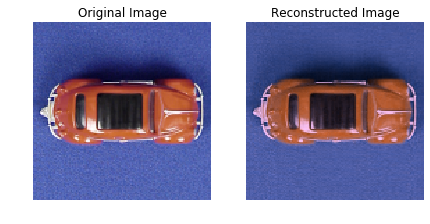

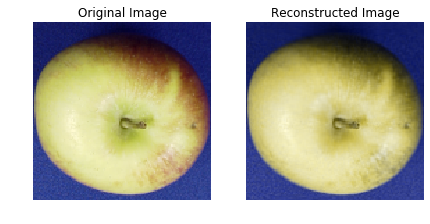

In [11]:
# Evaluate results
tensor_car_res = residual_tensor(tensor_car, tensor_car_tkd)
tensor_apple_res = residual_tensor(tensor_apple, tensor_apple_tkd)
rel_error_car = tensor_car_res.frob_norm / tensor_car.frob_norm
rel_error_apple = tensor_apple_res.frob_norm / tensor_apple.frob_norm
tensor_car_rec = tensor_car_tkd.reconstruct()
tensor_apple_rec = tensor_apple_tkd.reconstruct()

print("Relative error of approximation for the car = {}".format(rel_error_car))
print("Relative error of approximation for the apple = {}".format(rel_error_apple))
plot_tensors(tensor_car, tensor_car_rec)
plot_tensors(tensor_apple, tensor_apple_rec)

The original tensors are of size (128, 128, 3) and we use the HOOI algorithm to approximate them with a multi-linear rank of (50, 50, 2). The decreased resolution comes from a smaller sample size _(50 vs 128)_ in each mode. Also, only the two most significant channels are used to reconstruct the images. In other words, _G and R_ are discarded for _car_ and _apple_ respectively and compensated by the rest two colours. The size of the compressed images is 10 times smaller than the original ones, but the relative error is around 5%. Therefore, Tucker decomposition can be effectively applied to image compression.

### Solution: Part 2

In [12]:
# Create tensors from images
tensor_apple_top = Tensor(get_image(item="apple", view="top"))
tensor_apple_side = Tensor(get_image(item="apple", view="side"))
print("Tensor of the apple from the top: {}".format(tensor_apple_top))
print("--------------------")
print("Tensor of the apple from the side: {}".format(tensor_apple_side))

Tensor of the apple from the top: This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.
--------------------
Tensor of the apple from the side: This tensor is of order 3 and consists of 49152 elements.
Sizes and names of its modes are (128, 128, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


In [13]:
# Perform decomposition
rank = (50, 50, 2)
algorithm = HOOI()
tensor_apple_top_tkd = algorithm.decompose(tensor_apple_top, rank)
tensor_apple_side_tkd = algorithm.decompose(tensor_apple_side, rank)

Relative error of approximation for the apple = 0.03687270037558603
Relative error of approximation for the apple = 0.0656123187572973


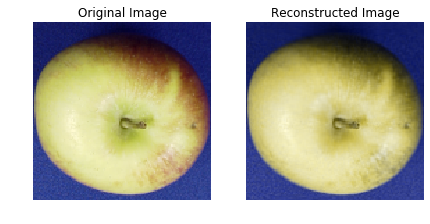

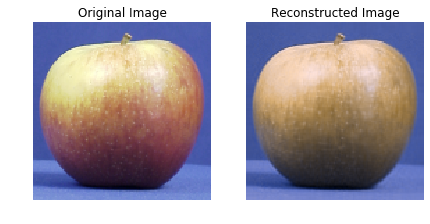

In [14]:
# Evaluate results
tensor_apple_top_res = residual_tensor(tensor_apple_top, tensor_apple_top_tkd)
tensor_apple_side_res = residual_tensor(tensor_apple_side, tensor_apple_side_tkd)
rel_error_apple_top = tensor_apple_top_res.frob_norm / tensor_apple_top.frob_norm
rel_error_apple_side = tensor_apple_side_res.frob_norm / tensor_apple_side.frob_norm
tensor_apple_top_rec = tensor_apple_top_tkd.reconstruct()
tensor_apple_side_rec = tensor_apple_side_tkd.reconstruct()

print("Relative error of approximation for the apple = {}".format(rel_error_apple_top))
print("Relative error of approximation for the apple = {}".format(rel_error_apple_side))
plot_tensors(tensor_apple_top, tensor_apple_top_rec)
plot_tensors(tensor_apple_side, tensor_apple_side_rec)

As mentioned above, the compression based on Tucker decomposition uses less samples and only the 2 most significant channels. The side view experiences a larger relative error of around 7% because the components of _R, G, B_ are more balanced and the percentage of minor colour is larger than the top view. Therefore, the influence of reducing one channel is more significant than that on the top view.

### Solution: Part 3

If the multi-linear rank corresponding to the channel reduce to 1, the approximation will be similar to grey-scale but expressed by the dominant colour _(i.e. "red-scale", "green-scale" or "blue-scale")_. It is equaivalent to the most significant single channel component.